In [10]:
%matplotlib inline
# Data manipulation
import pandas as pd
import os
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Widgets
import ipywidgets as wg
from IPython.display import display

Calcium diffusion once it enters the axon presents a difficult problem as it succumbs to multiple different fates. In the axon, there are calbindin buffer volume molecules, plasma membrane calcium (PMCA) pump surface molecules, and calcium sensor SNARE surface molecules. All of which bind and unbind calcium once it has entered the axon. Of particular interest is the amount of calcium which reaches the calcium sensors on the SNARE complex as this dictates the neurotransmitter release from presynaptic vesicles. The markov chains for all three fates can be seen here as well as their approximate spatial location.

<img src="./figs/axon_geom.png" width="400">

# Calcium Point Source Diffusion

<img src="./figs/diff.png" width="200">

In [38]:
N_SEEDS = 1
N_ITER = 500
ITER_START = 0
ITER_STEP = 1
AXON_R = 0.5
AXON_H = 4
N_CA = 5275 + 47
N_BINS = 4
CA_REL_LOC = (0.21, 0, -.249)

In [39]:
def load_data(MCELL_DIR):
    
    runs = {}
    
    # Add data to all arrays
    for seed in range(N_SEEDS):
        # Seed dir
        seed_loc = "seed_{:05d}".format(seed + 1)  # numbering starts at 1
        
        # Create 3D array for each seed (mol info x N mols x iteration)
        data = []
        
        for i in range(ITER_START, N_ITER, ITER_STEP):
            # Iter dir
            iter_loc = "Scene.ascii.{:04d}.dat".format(i)
            
            # Load data
            fname = os.path.join(MCELL_DIR, seed_loc, iter_loc)
            data_df = pd.read_csv(fname, delim_whitespace=True, header=None, 
                                  names=['type', 'id', 'x', 'y', 'z', 'norm_x', 'norm_y','norm_z'])
            
            # Adjust vdcc loc to be (x = 0, y = 0, z = 0)
            data_df['x'] = data_df['x'] - CA_REL_LOC[0]
            data_df['y'] = data_df['y'] - CA_REL_LOC[1]
            data_df['z'] = data_df['z'] - CA_REL_LOC[2]
            
            # Add radius column
            # Axon length runs along x direction
            data_df['r'] = np.sqrt(data_df['y']**2 + data_df['z']**2)
            
            # Add to data list
            data.append(data_df)
        
        # Append to dict
        runs[seed_loc] = data
        
    return runs
    

In [43]:
def diff_scatter_plot(runs, seed=1, timepoint=1):
    '''Creates a scatter plot for the current integer run of interest'''
    # Seed name
    seed_loc = "seed_{:05d}".format(seed)  # numbering starts at 1
    
    # Look at single iteration
    tp_idx = timepoint - 1
    
    r = runs[seed_loc][tp_idx]['r'] # radius is 0 to 0.5
    h = runs[seed_loc][tp_idx]['x'] # height is -2.0 to 2.0
    
    fig = plt.figure()
    ax = plt.axes(xlim=(- AXON_H/2 + CA_REL_LOC[2], AXON_H/2 + CA_REL_LOC[2] + 0.05), 
                  ylim=(0 - 0.01, AXON_R + 0.01))
    
    ax.set_xlabel('axon length')
    ax.set_xlim((-0.5, 0.5))
    ax.set_ylabel('axon radius')
    plt.scatter(h, r, alpha=0.2)
    plt.scatter(-0.21, 0, color='k')
    plt.show()
    

In [28]:
def diff_3D_plot(runs, seed=1, timepoint=1):
    '''Creates a 3D bar plot for the current integer run of interest'''
    # Seed name
    seed_loc = "seed_{:05d}".format(seed)  # numbering starts at 1
    
    # Look at single iteration
    tp_idx = timepoint - 1
    
    r = runs[seed_loc][tp_idx]['r'] # radius is 0 to 0.5
    h = runs[seed_loc][tp_idx]['x'] # height is -2.0 to 2.0
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Obtain histogram for 2d
    hist, xedges, yedges = np.histogram2d(r, h, bins=N_BINS, 
                                          range=[[0, AXON_R], 
                                                 [- AXON_H/2 + CA_REL_LOC[2], AXON_H/2 + CA_REL_LOC[2]]])
    
    # Construct arrays for anchor positions of bars
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    
    # Construct array with the dimensions for the bars
    # distance between bin vals
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = (hist/N_CA).ravel()
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
    
    ax.set_xlabel('r')
    ax.set_ylabel('h')
    ax.set_zlabel('fraction')

    plt.show()
    

In [40]:
%matplotlib inline
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_diff_files/mcell/output_data/viz_ascii_data/"
runs = load_data(MCELL_DIR)

In [44]:
tp_slide = wg.IntSlider(value=1, min=1, max=100)
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_scatter_plot, runs=wg.fixed(runs), seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

In [8]:
tp_slide = wg.IntSlider(value=1, min=1, max=int(N_ITER/ITER_STEP))
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_3D_plot, runs=wg.fixed(runs), seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

<IPython.core.display.Javascript object>


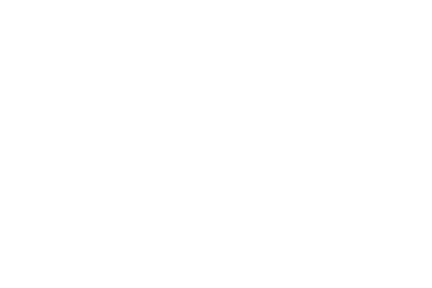

<IPython.core.display.Javascript object>


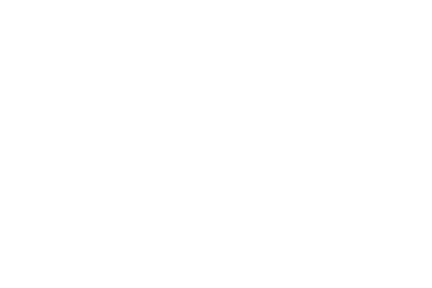

In [9]:
from importlib import reload
reload(plt)
%matplotlib notebook
diff_3D_plot(runs,1,1)

In [42]:
%matplotlib inline
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_diffCalb_files/mcell/output_data/viz_ascii_data/"
runs_calb = load_data(MCELL_DIR)

FileNotFoundError: [Errno 2] File b'/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_diffCalb_files/mcell/output_data/viz_ascii_data/seed_00001/Scene.ascii.0000.dat' does not exist: b'/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_diffCalb_files/mcell/output_data/viz_ascii_data/seed_00001/Scene.ascii.0000.dat'

In [12]:
tp_slide = wg.IntSlider(value=1, min=1, max=int(N_ITER/ITER_STEP))
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_scatter_plot, seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

In [13]:
tp_slide = wg.IntSlider(value=1, min=1, max=int(N_ITER/ITER_STEP))
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_3D_plot, seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

<IPython.core.display.Javascript object>


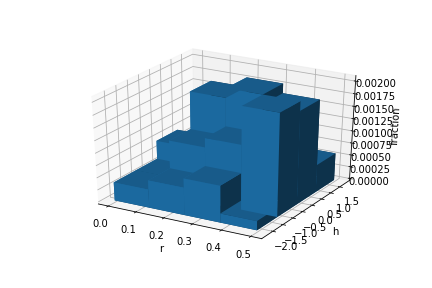

In [14]:
reload(plt)
%matplotlib notebook
diff_3D_plot(1,50)

In [17]:
%matplotlib inline
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/data/model1_cylAxon_diffPmca/viz_ascii_data/"
runs_pmca = load_data(MCELL_DIR)

In [18]:
tp_slide = wg.IntSlider(value=1, min=1, max=int(N_ITER/ITER_STEP))
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_scatter_plot, runs=wg.fixed(runs_pmca), seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

In [19]:
tp_slide = wg.IntSlider(value=1, min=1, max=int(N_ITER/ITER_STEP))
seed_slide = wg.IntSlider(value=1, min=1, max=N_SEEDS)
wg.interact(diff_3D_plot, runs=wg.fixed(runs_pmca), seed=seed_slide, timepoint=tp_slide)
plt.show()

interactive(children=(IntSlider(value=1, description='seed', max=1, min=1), IntSlider(value=1, description='ti…

<IPython.core.display.Javascript object>


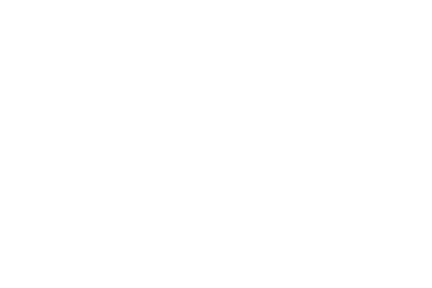

<IPython.core.display.Javascript object>


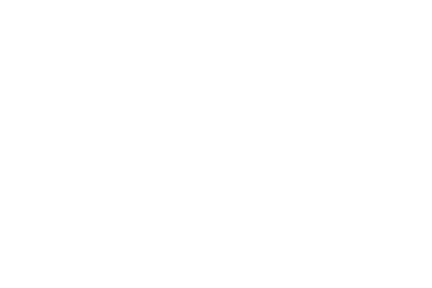

In [16]:
#reload(plt)
#%matplotlib notebook
#diff_3D_plot(runs_pmca,1,50)